# Dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import yfinance as yf

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from numpy.linalg import inv, eig, svd
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix 
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

from matplotlib.ticker import FuncFormatter

# Definitions and Data

In [2]:
# load dataset
#scraping wikipedia to fetch S&P 500 and DJI stock list
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP_stocks = pd.read_html(snp500url)[0]
SP_tickers = SP_stocks['Symbol'].to_list()

DJI = (
    pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[1]
)
DJI_symbols = DJI.Symbol.tolist()

In [3]:
def download_stocks(tickers,start='2014-01-01',end='2019-01-01'):
    return yf.download(tickers, start = start, end = end)

def remove_null(df, cutoff = .99):
    df = df.dropna(thresh=int(df.shape[0]*cutoff),axis=1)
    df = df.dropna(thresh=int(df.shape[1]*cutoff))
    return df

def winsorize(df,q=.025):
    clipped = df.clip(lower=df.quantile(q=q),
                   upper=df.quantile(q=1-q),
                   axis=1)
    return clipped

def df_scaler(df):
    scaler = StandardScaler().fit(df)
    return scaler

def train_test_split(df,percentage = .8):
    
    train_size = int(len(df)*percentage)
    train_set = df[:train_size]
    test_set = df[train_size:]
    
    return train_set, test_set

def normalize_data(df_train,df_test):
    scaler = StandardScaler().fit(df_train)
    
    train = pd.DataFrame(scaler.transform(df_train),
                         columns = df_train.columns,
                         index = df_train.index)
    
    test = pd.DataFrame(scaler.transform(df_test),
                        columns = df_test.columns,
                        index = df_test.index)
    
    return train, test


def get_distance_matrix(corr):
    """Compute distance matrix from correlation;
    0 <= d[i,j] <= 1"""
    return np.sqrt((1 - corr) / 2)

def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        #sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = pd.concat([sort_idx,df0])
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

def clustered_corr_plot(df,include_ticks = True):
    corr = df.corr()
    
    distance_matrix = get_distance_matrix(corr)
    linkage_matrix = linkage(squareform(distance_matrix), 'single')
    sorted_idx = quasi_diagonalize(linkage_matrix)
    
    clustergrid = sns.clustermap(distance_matrix, 
                             method='single', 
                             row_linkage=linkage_matrix, 
                             col_linkage=linkage_matrix, 
                             center=0);
    plt.close()
    
    sorted_idx = clustergrid.dendrogram_row.reordered_ind
    sorted_tickers = corr.index[sorted_idx].tolist()
    fig, ax = plt.subplots(figsize=(18, 8))

    #sns.heatmap(corr, center = 0, ax=axes[0])
    #axes[0].set_title('Correlation Matrix')
    #fig.tight_layout()

    clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder
    
    sns.heatmap(clustered_assets, center = 0, ax=ax)
    ax.set_title('Clustered Correlation')
    if not include_ticks:
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout();
    
    return fig

In [4]:
SP_index = download_stocks('^GSPC')['Adj Close']
DJI_index = download_stocks('^DJI')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


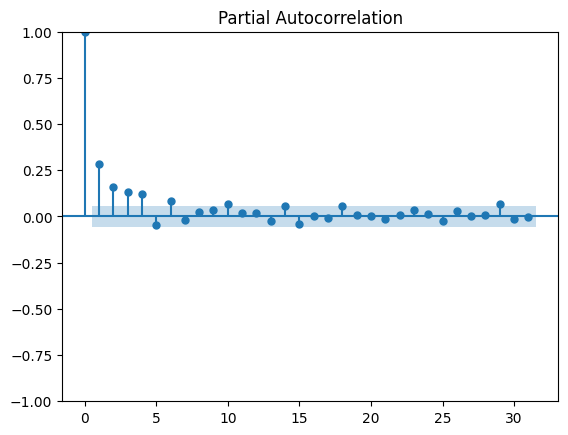

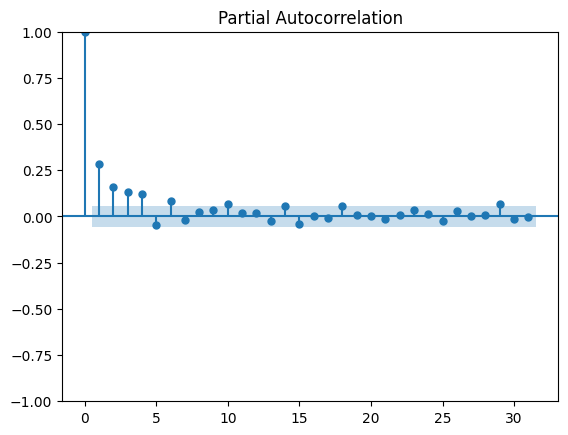

In [243]:
plot_pacf(SP_idx_returns**2)

In [5]:
SP_idx_returns = SP_index.pct_change().dropna()
DJI_idx_returns = DJI_index.pct_change().dropna()

In [6]:
SP_data = download_stocks(SP_tickers)['Adj Close']
SP_data.index = pd.to_datetime(SP_data.index)

DJI_data = download_stocks(DJI_symbols)['Adj Close']
DJI_data.index = pd.to_datetime(DJI_data.index)

SP_data = remove_null(SP_data)
DJI_data = remove_null(DJI_data)

[*********************100%***********************]  503 of 503 completed


12 Failed downloads:
['OTIS', 'FOX', 'DOW', 'CTVA', 'CARR', 'CEG', 'GEHC', 'FOXA', 'OGN']: Exception("%ticker%: Data doesn't exist for startDate = 1388552400, endDate = 1546318800")
['BF.B', 'AAPL']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2014-01-01 -> 2019-01-01)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%***********************]  30 of 30 completed


1 Failed download:
['DOW']: Exception("%ticker%: Data doesn't exist for startDate = 1388552400, endDate = 1546318800")


In [7]:
print(SP_data.isna().sum().sum())
print(DJI_data.isna().sum().sum())

0
0


# Data Processing

In [14]:
#SP_returns = SP_data.pct_change().dropna()
#dji_returns = dji_data.pct_change().dropna()

#SP_log_returns = np.log(SP_data/SP_data.shift(1))[1:]
#dji_log_returns = np.log(dji_data/dji_data.shift(1))[1:]
#
#SP_log_returns = winsorize(SP_log_returns)
#dji_log_returns = winsorize(dji_log_returns)

SP_returns = SP_data.pct_change().dropna()
DJI_returns = DJI_data.pct_change().dropna()

SP_returns = winsorize(SP_returns)
DJI_returns = winsorize(DJI_returns)

In [15]:
#SP_train, SP_test = train_test_split(SP_log_returns)
#dji_train, dji_test = train_test_split(dji_log_returns)

SP_train, SP_test = train_test_split(SP_returns)
DJI_train, DJI_test = train_test_split(DJI_returns)

In [16]:
SP_train_scaled = (SP_train-SP_train.mean())/SP_train.std()
SP_test_scaled = (SP_test-SP_train.mean())/SP_train.std()

DJI_train_scaled = (DJI_train-DJI_train.mean())/DJI_train.std()
DJI_test_scaled = (DJI_test-DJI_train.mean())/DJI_train.std()

In [17]:
print('Statistics for SP-500 train set')
print(f'Average normalized return: {SP_train_scaled.mean().mean()}')
print(f'Average standard deviation: {SP_train_scaled.std().mean()}')
print('\n')
print('Statistics for SP-500 test set')
print(f'Average normalized return: {SP_test_scaled.mean().mean()}')
print(f'Average standard deviation: {SP_test_scaled.std().mean()}')

Statistics for SP-500 train set
Average normalized return: 1.4179725271814578e-18
Average standard deviation: 1.0


Statistics for SP-500 test set
Average normalized return: -0.04913931337662954
Average standard deviation: 1.1328316837124488


In [18]:
print('Statistics for DJI train set')
print(f'Average normalized return: {DJI_train_scaled.mean().mean()}')
print(f'Average standard deviation: {DJI_train_scaled.std().mean()}')
print('\n')
print('Statistics for DJI test set')
print(f'Average normalized return: {DJI_test_scaled.mean().mean()}')
print(f'Average standard deviation: {DJI_test_scaled.std().mean()}')

Statistics for DJI train set
Average normalized return: 9.096629208457281e-18
Average standard deviation: 1.0


Statistics for DJI test set
Average normalized return: -0.029212695796527573
Average standard deviation: 1.2158628042358774


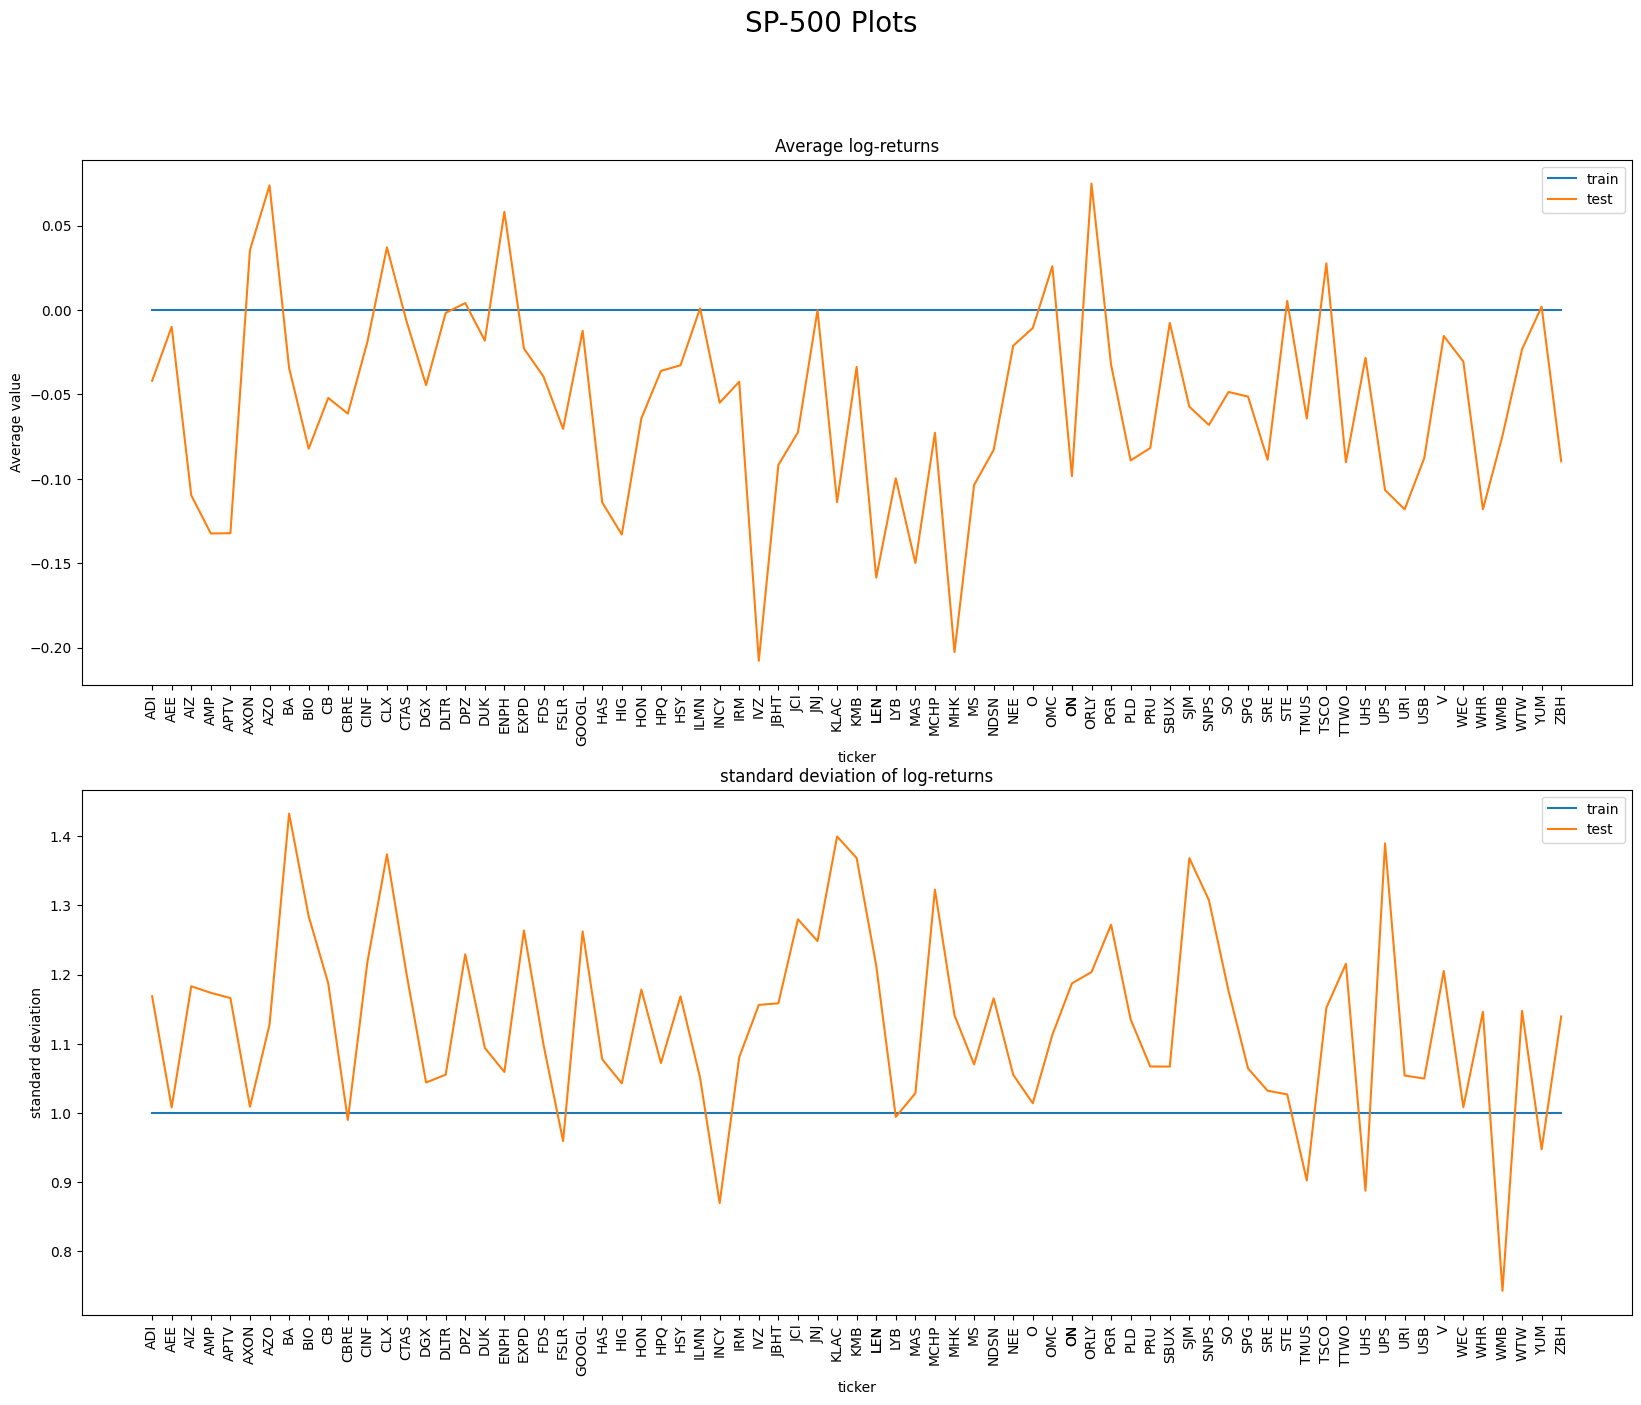

In [19]:
fig, axes = plt.subplots(2,sharex=False)
fig.set_size_inches(20, 15)

np.random.seed(110)

random_stocks = sorted(np.random.choice(SP_train_scaled.shape[1],75))
random_tickers = list(SP_train_scaled.columns[random_stocks])

SP_train_scaled_sample = SP_train_scaled[random_tickers]
SP_test_scaled_sample = SP_test_scaled[random_tickers]

axes[0].plot(SP_train_scaled_sample.mean(),label='train')
axes[0].plot(SP_test_scaled_sample.mean(),label='test')
axes[0].set_title('Average log-returns')
axes[0].set_ylabel('Average value')
axes[0].legend()

axes[0].set_xlabel('ticker')
axes[0].set_xticks(random_tickers)
axes[0].set_xticklabels(random_tickers,rotation=90)

#plt.draw()
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)

axes[1].plot(SP_train_scaled_sample.std(),label='train')
axes[1].plot(SP_test_scaled_sample.std(),label='test')
axes[1].set_title('standard deviation of log-returns')
axes[1].set_ylabel('standard deviation')
axes[1].legend()


axes[1].set_xlabel('ticker')
axes[1].set_xticks(random_tickers)
axes[1].set_xticklabels(random_tickers,rotation=90);

plt.suptitle('SP-500 Plots',fontsize=20)

plt.show();

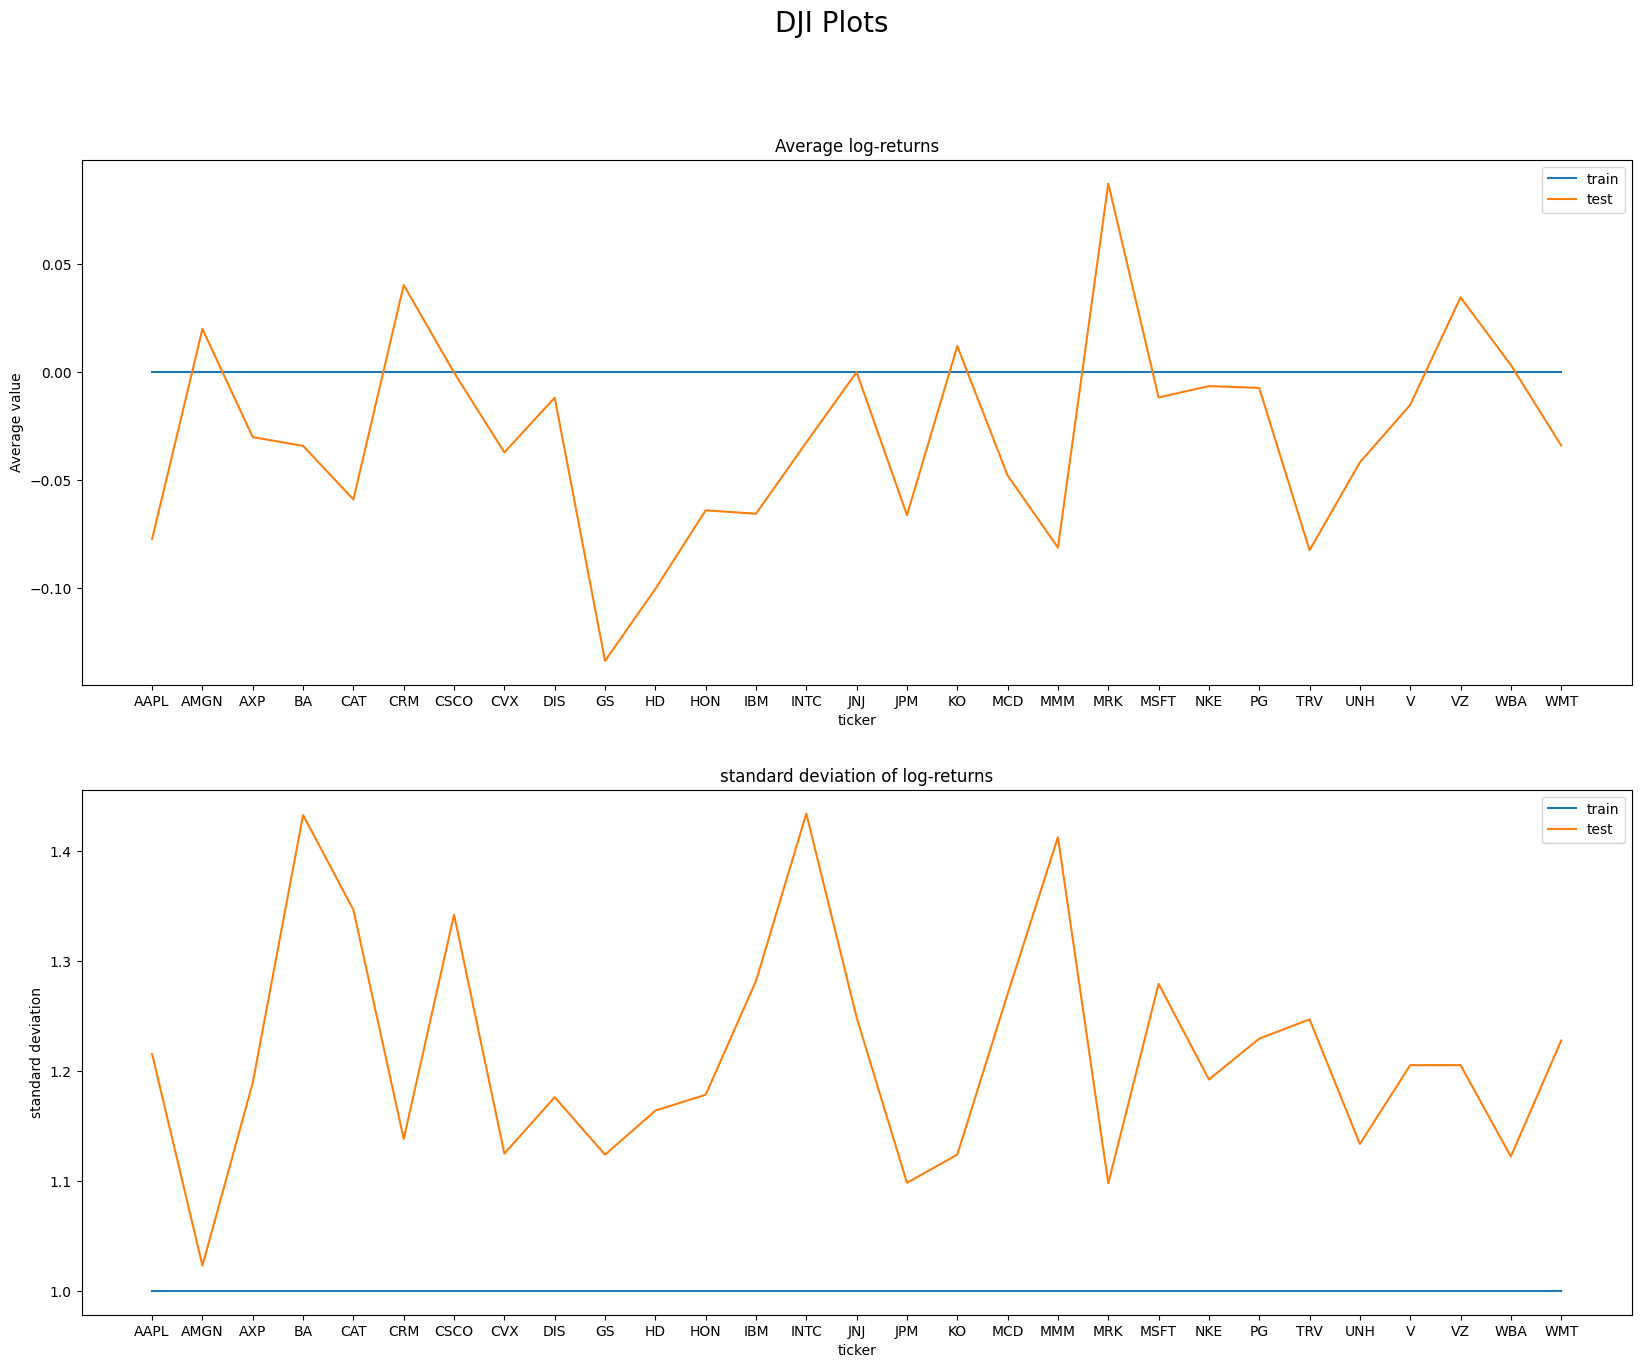

In [20]:
fig, axes = plt.subplots(2,sharex=False)
fig.set_size_inches(20, 15)

axes[0].plot(DJI_train_scaled.mean(),label='train')
axes[0].plot(DJI_test_scaled.mean(),label='test')
axes[0].set_title('Average log-returns')
axes[0].set_ylabel('Average value')
axes[0].legend()

axes[0].set_xlabel('ticker')
#axes[0].set_xticks(random_tickers)
#axes[0].set_xticklabels(random_tickers,rotation=90)

#plt.draw()
#axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)

axes[1].plot(DJI_train_scaled.std(),label='train')
axes[1].plot(DJI_test_scaled.std(),label='test')
axes[1].set_title('standard deviation of log-returns')
axes[1].set_ylabel('standard deviation')
axes[1].legend()


axes[1].set_xlabel('ticker')


plt.suptitle('DJI Plots',fontsize=20)

plt.show();

In [21]:
SP_train_cov = SP_train.cov()
SP_test_cov = SP_test.cov()

SP_train_corr = SP_train.corr()
SP_test_corr = SP_test.corr()

DJI_train_cov = DJI_train.cov()
DJI_test_cov = DJI_test.cov()

DJI_train_corr = DJI_train.corr()
DJI_test_corr = DJI_test.corr()

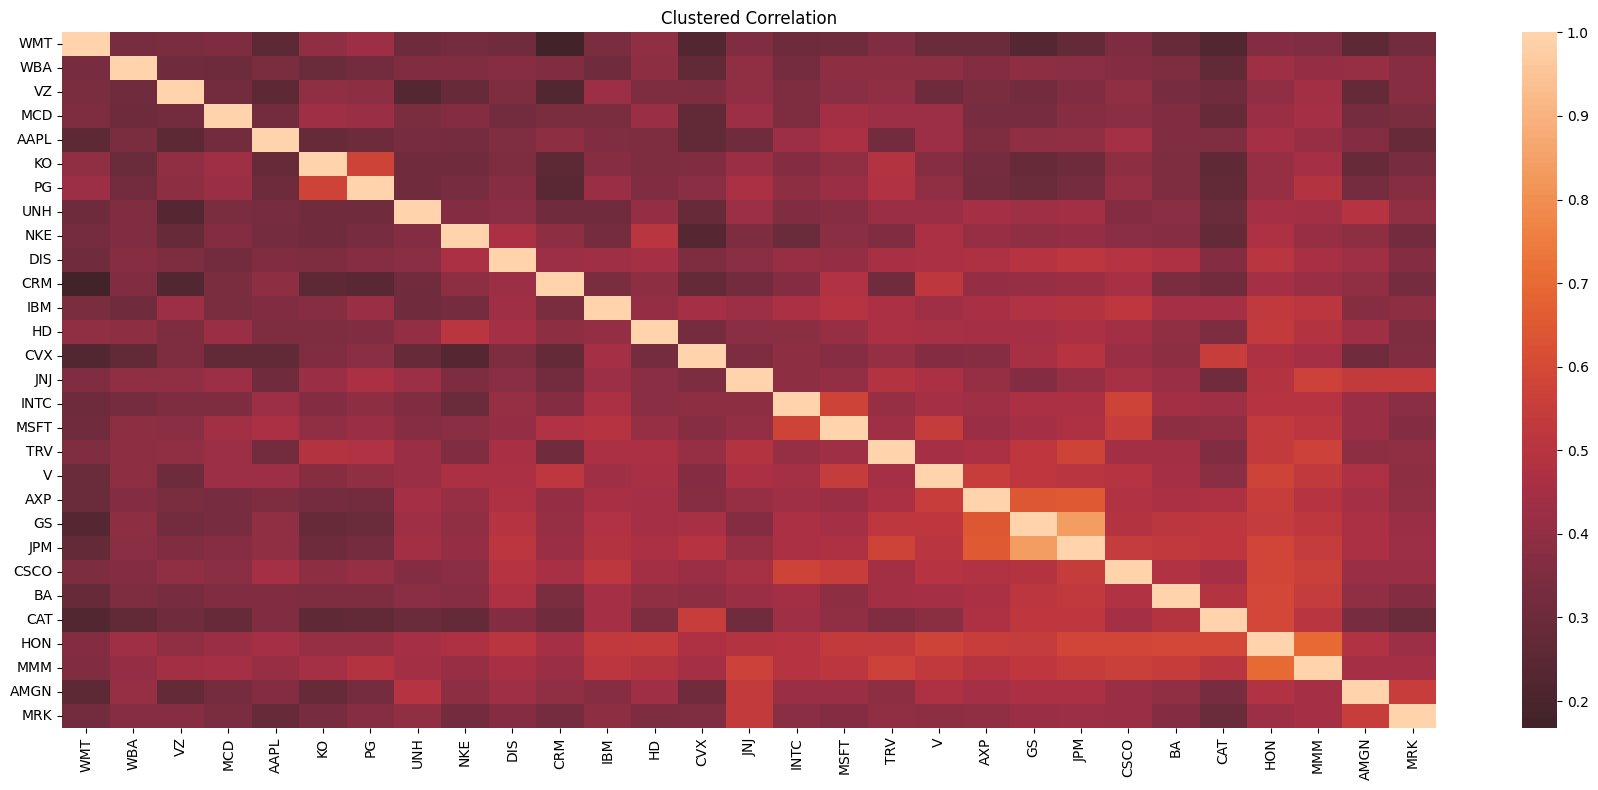

In [22]:
clustered_corr_plot(DJI_train);

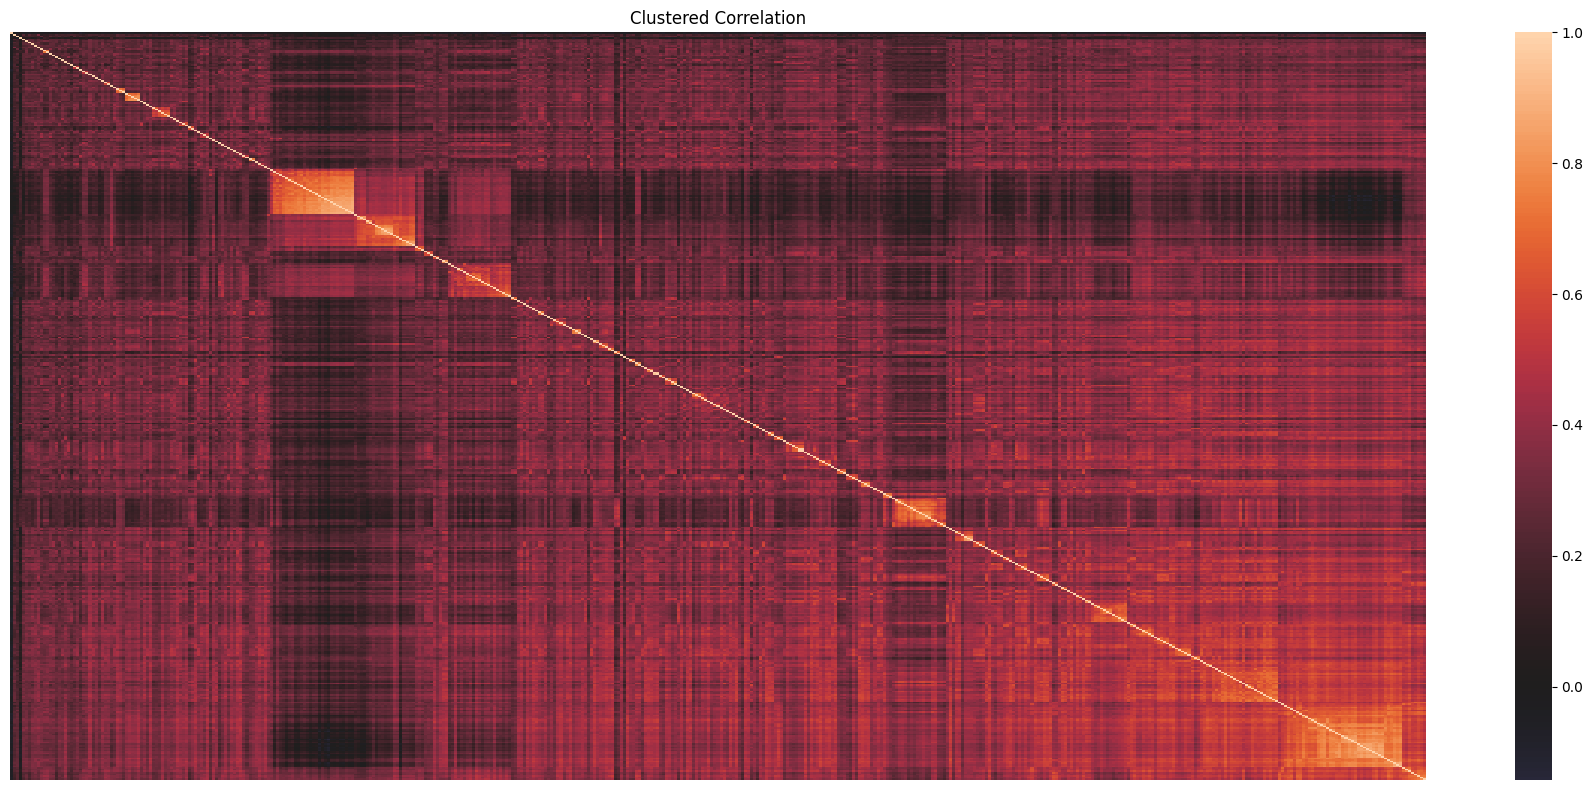

In [23]:
clustered_corr_plot(SP_train,include_ticks=False);

In [24]:
PCA_SP = PCA().fit(SP_train_scaled)
PCA_DJI = PCA().fit(DJI_train_scaled)

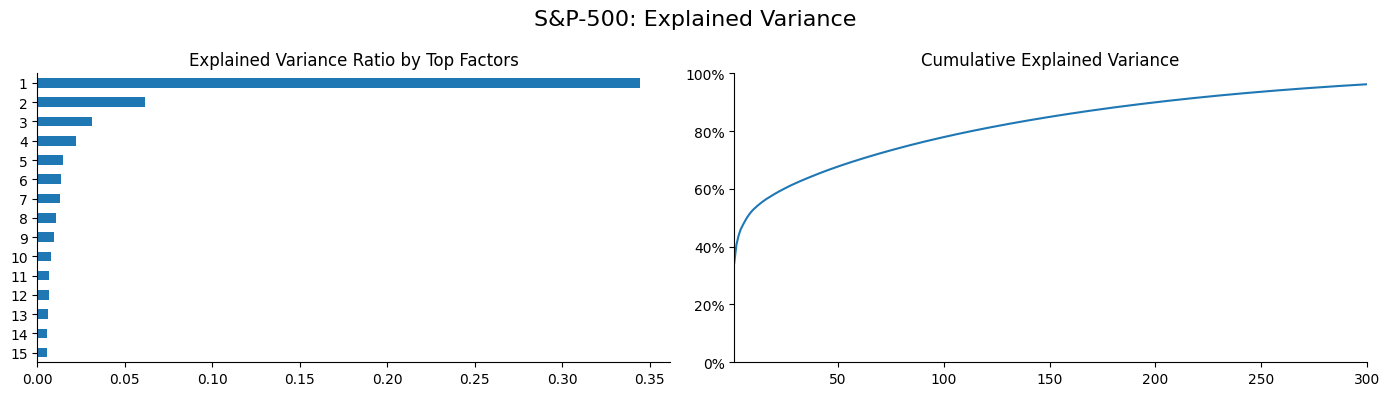

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(PCA_SP.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.suptitle("S&P-500: Explained Variance", size=16)
fig.tight_layout()

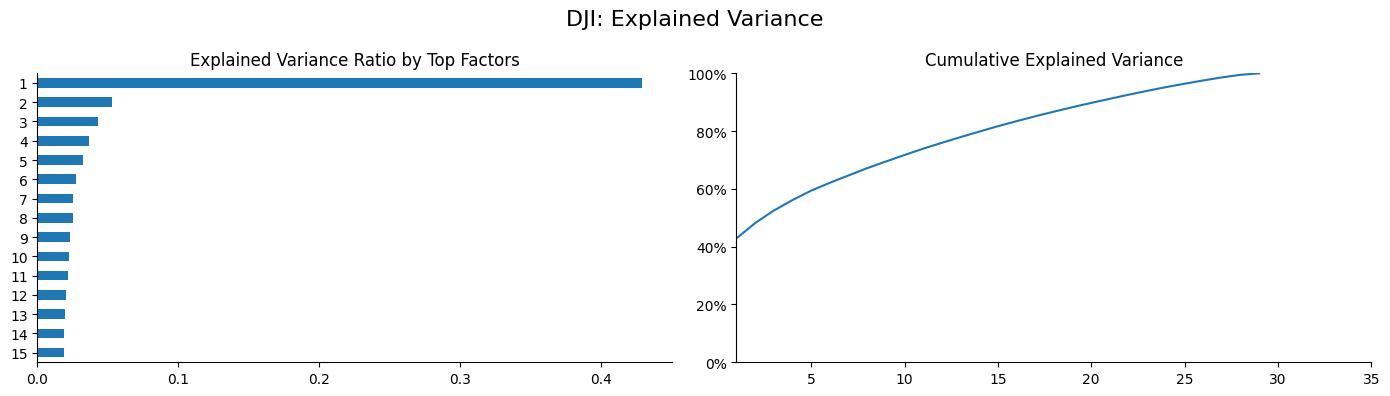

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(PCA_DJI.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 35))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.suptitle("DJI: Explained Variance", size=16)
fig.tight_layout()

In [27]:
DJI_eigvals, DJI_eigvecs = np.linalg.eigh(DJI_train_corr)

DJI_eigvals = DJI_eigvals[::-1]
DJI_eigvecs = DJI_eigvecs[:,::-1]

print(np.allclose(PCA_DJI.explained_variance_ratio_,(DJI_eigvals/np.sum(DJI_eigvals))))

print(np.allclose(np.abs(np.dot(PCA_DJI.components_,DJI_eigvecs)),
            np.eye(DJI_eigvecs.shape[0])))

True
True


In [28]:
SP_eigvals, SP_eigvecs = np.linalg.eigh(SP_train_corr)

SP_eigvals = SP_eigvals[::-1]
SP_eigvecs = SP_eigvecs[:,::-1]

print(np.allclose(PCA_SP.explained_variance_ratio_,(SP_eigvals/np.sum(SP_eigvals))))

print(np.allclose(np.abs(np.dot(PCA_SP.components_,SP_eigvecs)),
            np.eye(SP_eigvecs.shape[0])))

True
True


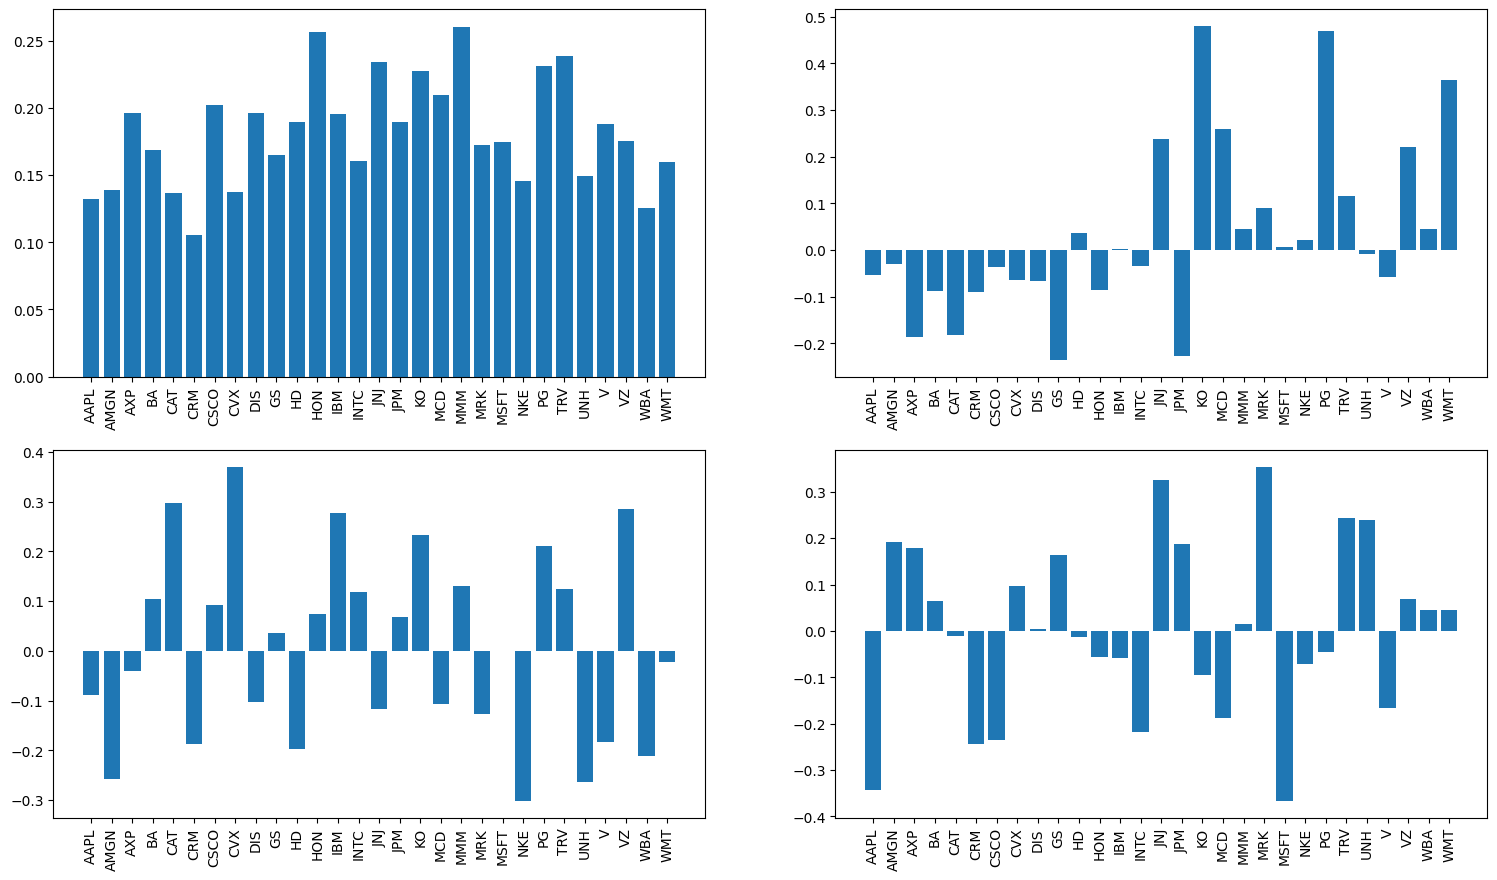

In [78]:
fig, axes = plt.subplots(2,2,sharex=False)

axes[0,0].bar(np.arange(29),
              (DJI_evecs_std[:,0]/np.linalg.norm(DJI_evecs_std[:,0])),
             tick_label=DJI_train.columns);
axes[0,1].bar(np.arange(29),(DJI_evecs_std[:,1]/np.linalg.norm(DJI_evecs_std[:,1])),
             tick_label=DJI_train.columns);
axes[1,0].bar(np.arange(29),(DJI_evecs_std[:,2]/np.linalg.norm(DJI_evecs_std[:,2])),
             tick_label=DJI_train.columns);
axes[1,1].bar(np.arange(29),(DJI_evecs_std[:,3]/np.linalg.norm(DJI_evecs_std[:,3])),
             tick_label=DJI_train.columns);

#axes[0,0].set_xticks(np.arange(29),labels=list(DJI_train.columns),rotation=45);

for i in range(2):
    for j in range(2):
        axes[i,j].set_xticklabels(DJI_train.columns,rotation=90)

fig.set_size_inches(18.5, 10.5)
#axes[0,0].set_xlabel('ticker')
#axes[0,0].set_xticks(np.arange(29));
#axes[0,0].set_xticklabels(DJI_train.columns,rotation=90);

In [79]:
DJI_evecs_std = (DJI_eigvecs.T/(DJI_train.std().values)).T

np.allclose((DJI_train.dot(DJI_evecs_std)).corr().values,
            np.eye(DJI_evecs_std.shape[0]))

True

In [80]:
SP_evecs_std = (SP_eigvecs.T/(SP_train.std().values)).T

np.allclose((SP_train.dot(SP_evecs_std)).corr().values,
            np.eye(SP_evecs_std.shape[0]))

True

In [39]:
for i in range(DJI_evecs_std.shape[1]):
    #DJI_evecs_std[:,i]=DJI_evecs_std[:,i]/np.linalg.norm(DJI_evecs_std[:,i])
    DJI_evecs_std[:,i]=DJI_evecs_std[:,i]/np.sum(DJI_evecs_std[:,i])
    
for i in range(SP_evecs_std.shape[1]):
    #SP_evecs_std[:,i]=SP_evecs_std[:,i]/np.linalg.norm(SP_evecs_std[:,i])
    SP_evecs_std[:,i]=SP_evecs_std[:,i]/np.sum(SP_evecs_std[:,i])

In [35]:
DJI_eport_train = DJI_train.dot(DJI_evecs_std)
DJI_eport_test = DJI_test.dot(DJI_evecs_std)

SP_eport_train = SP_train.dot(SP_evecs_std)
SP_eport_test = SP_test.dot(SP_evecs_std)

In [60]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a single eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year

    annualized_return_pos = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_return_neg = np.power(np.prod(1-ts_returns),(1/n_years))-1
    
    annualized_return = max(annualized_return_pos,annualized_return_neg)
    
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

In [81]:
SP_train_sharpe = np.zeros((SP_eport_train.shape[1],3))

for i, col in enumerate(SP_eport_train.columns):
    SP_train_sharpe[i] = sharpe_ratio(SP_eport_train[col])

df_SP_summary = pd.DataFrame(SP_train_sharpe,columns=['return','vol','sharpe'],
             index=np.arange(SP_train_sharpe.shape[0]))

df_SP_summary.sort_values(by='sharpe',ascending=False)[:5]

,return,vol,sharpe
458,0.070757,0.033499,2.112198
447,0.081187,0.039183,2.071968
461,0.068198,0.034041,2.003392
430,0.087860,0.045131,1.946775
420,0.089761,0.048044,1.868287


In [83]:
SP_test_sharpe = np.zeros((SP_eport_test.shape[1],3))

for i, col in enumerate(SP_eport_test.columns):
    SP_test_sharpe[i] = sharpe_ratio(SP_eport_test[col])

df_SP_test_summary = pd.DataFrame(SP_test_sharpe,columns=['return','vol','sharpe'],
             index=np.arange(SP_test_sharpe.shape[0]))

df_SP_test_summary.sort_values(by='sharpe',ascending=False)[:5]

,return,vol,sharpe
339,0.518025,0.118313,4.378441
41,0.842477,0.233925,3.601485
257,0.377562,0.126257,2.990431
341,0.370749,0.126026,2.941836
312,0.344276,0.121949,2.823107


In [90]:
DJI_train_sharpe = np.zeros((DJI_eport_train.shape[1],3))

for i, col in enumerate(DJI_eport_train.columns):
    DJI_train_sharpe[i] = sharpe_ratio(DJI_eport_train[col])

df_DJI_summary = pd.DataFrame(DJI_train_sharpe,columns=['return','vol','sharpe'],
             index=np.arange(DJI_train_sharpe.shape[0]))

df_DJI_summary.sort_values(by='sharpe',ascending=False)[:10]

,return,vol,sharpe
0,0.828519,0.567442,1.460095
6,0.149839,0.147320,1.017095
26,0.070914,0.094488,0.750506
10,0.096677,0.128887,0.750086
13,0.082354,0.116784,0.705187
5,0.085706,0.129889,0.659845
25,0.059143,0.093147,0.634940
11,0.077800,0.128198,0.606875
28,0.042619,0.072576,0.587226
19,0.054504,0.103475,0.526735


In [89]:
DJI_test_sharpe = np.zeros((DJI_eport_test.shape[1],3))

for i, col in enumerate(DJI_eport_test.columns):
    DJI_test_sharpe[i] = sharpe_ratio(DJI_eport_test[col])

df_DJI_test_summary = pd.DataFrame(DJI_test_sharpe,columns=['return','vol','sharpe'],
             index=np.arange(DJI_test_sharpe.shape[0]))

df_DJI_test_summary.sort_values(by='sharpe',ascending=False)[:10]

,return,vol,sharpe
14,0.301449,0.119401,2.524666
28,0.195131,0.092843,2.101734
4,0.271522,0.171901,1.579525
2,0.266631,0.187249,1.423939
25,0.131600,0.108598,1.211802
24,0.087510,0.099560,0.878963
1,0.185605,0.238729,0.777471
7,0.128488,0.166191,0.773133
6,0.106249,0.172037,0.617594
13,0.059491,0.127508,0.466570


# Dimensionality Reduction

In [150]:
PCA_SP_dr = PCA(n_components = 'mle').fit(SP_train_scaled)
PCA_DJI_dr = PCA(n_components = 'mle').fit(DJI_train_scaled)

In [151]:
SP_train_reconst = PCA_SP_dr.inverse_transform(
    PCA_SP_dr.transform(SP_train_scaled))
SP_test_reconst = PCA_SP_dr.inverse_transform(
    PCA_SP_dr.transform(SP_test_scaled))


DJI_train_reconst = PCA_DJI_dr.inverse_transform(
    PCA_DJI_dr.transform(DJI_train_scaled))
DJI_test_reconst = PCA_DJI_dr.inverse_transform(
    PCA_DJI_dr.transform(DJI_test_scaled))

In [156]:
print(np.sqrt(np.linalg.norm(SP_train_reconst-SP_train_scaled.values,
               ord='fro')/np.linalg.norm(SP_train_scaled.values,
               ord='fro')))

print(np.sqrt(np.linalg.norm(SP_test_reconst-SP_test_scaled.values,
               ord='fro')/np.linalg.norm(SP_test_scaled.values,
               ord='fro')))

0.6905215300401172
0.7424276193542869


In [157]:
print(np.sqrt(np.linalg.norm(DJI_train_reconst-DJI_train_scaled.values,
               ord='fro')/np.linalg.norm(DJI_train_scaled.values,
               ord='fro')))

print(np.sqrt(np.linalg.norm(DJI_test_reconst-DJI_test_scaled.values,
               ord='fro')/np.linalg.norm(DJI_test_scaled.values,
               ord='fro')))

0.2676614948515024
0.2745404015559112


# Time-Series

In [195]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags

    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)

        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])

        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'

        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)

        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'

        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)

        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0],auto_ylims=True)
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1],auto_ylims=True)

        axes[1][0].set_xlabel('Lag')

        axes[1][1].set_xlabel('Lag')

        fig.suptitle(title, fontsize=14)

        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

In [225]:
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf

In [230]:
adfuller(DJI_eport_train[0])[1]

0.0

In [237]:
acf(DJI_eport_train[0], nlags=2)

array([ 1.        , -0.05123866, -0.01175437])

In [236]:
q_stat(acf(DJI_eport_train[0], nlags=2),
       len(DJI_eport_train[0]))

(array([1008.00298805, 1010.65203815, 1010.79158706]),
 array([3.27123424e-221, 3.46496102e-220, 8.20532120e-219]))

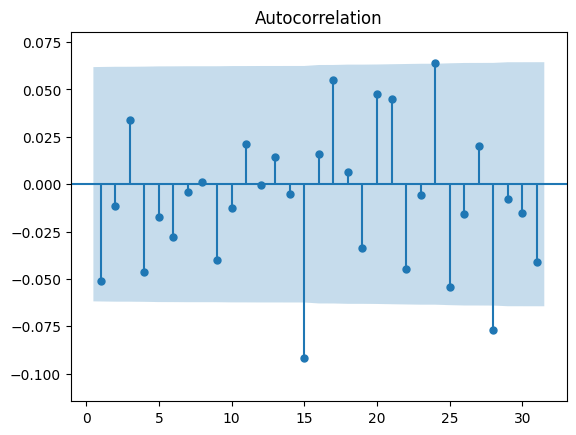

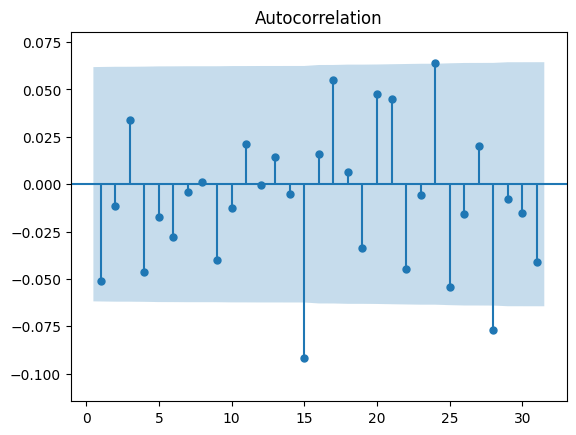

In [240]:
plot_acf(DJI_eport_train[0],zero=False,auto_ylims=True)

/Users/davidmeltzer/miniconda3/envs/obb/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


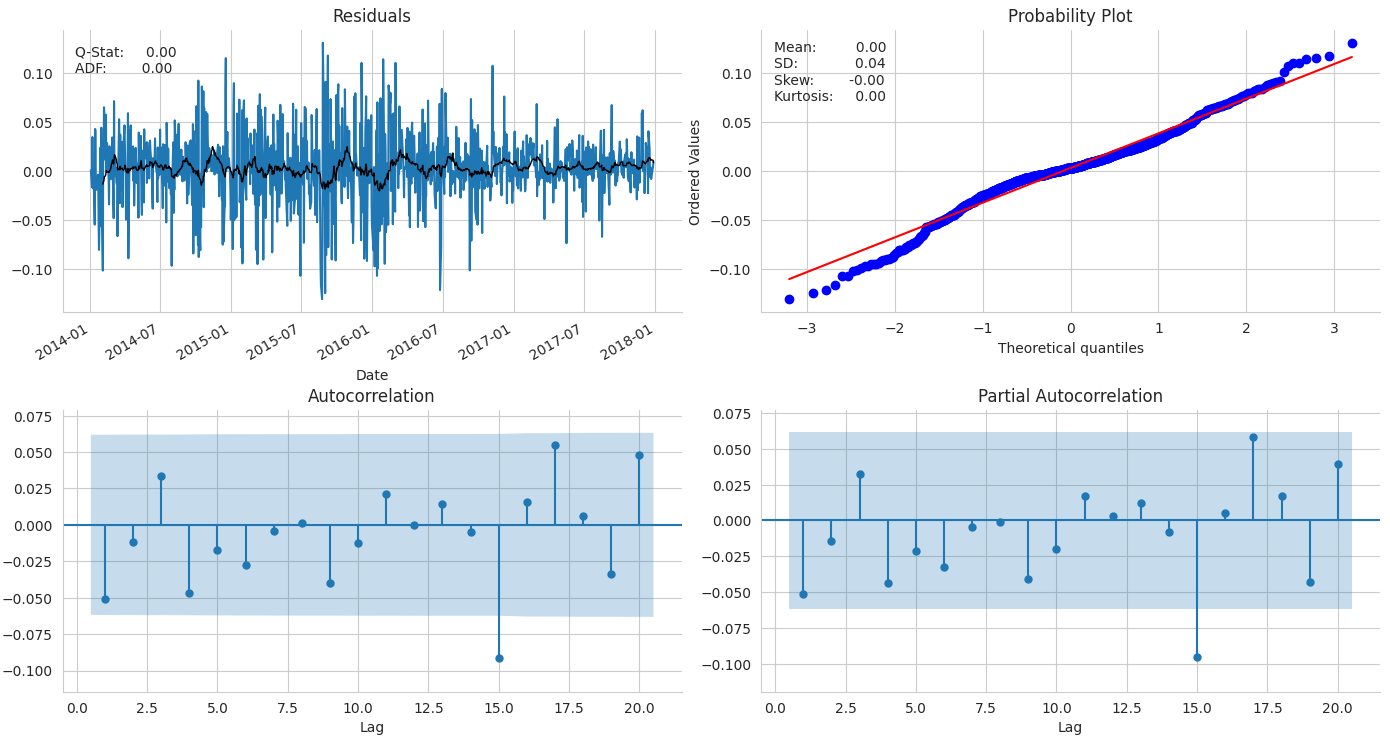

In [234]:
plot_correlogram(DJI_eport_train[0],lags=20)

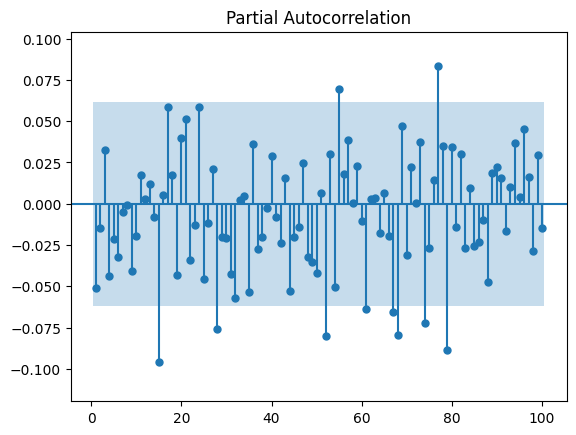

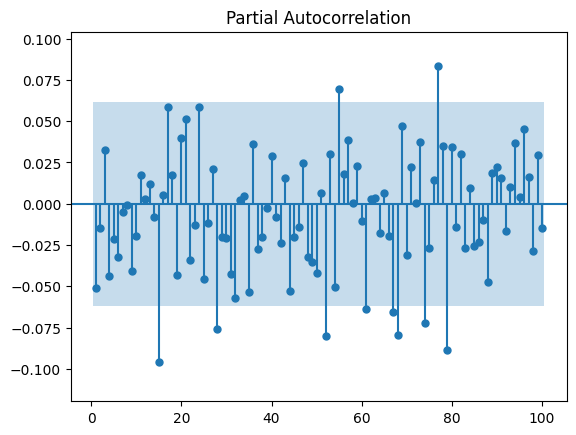

In [201]:
plot_pacf(DJI_eport_train[0],
         zero=False,
         auto_ylims=True,
         lags = 100,
         alpha = 0.05)